# Data Analysis of the Ford GoBike's trip data

## Investigation Overview

In this investigation we will look into aspects of how long is the typical bike trip duration?
During what weekdays does bike trips occur?
Is is possible to see sightseeing bike trips?
During which hours of the day does bike trips start?


## Dataset Overview

The data consist of over 2 million bike trips collected between january 2018 and february 2019. The attributes include start and stop station with date and time, user type. No data points was removed from the datasets that where downloaded from the Ford GoBike's trip data for public use.

In [1]:
import requests
import os, sys
import pandas as pd
import numpy as np
import zipfile
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark", color_codes=True, context='talk', palette='muted', rc={"lines.linewidth": 2})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
DATA_DIR = 'data'
IMAGES_DIR = 'images'

def ensure_dir(file_path=IMAGES_DIR):
    """
    Ensure directory exists or create it.
    :param file_path: directory path
    :return: 
    """
    if not os.path.exists(file_path):
        os.makedirs(file_path)


# load data source files and make one DataFrame
tripdata_files = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv') and os.path.isfile(os.path.join(DATA_DIR, file))]
dataframes = [pd.read_csv(os.path.join(DATA_DIR, file)) for file in tripdata_files]

bikeshare_df = pd.concat(dataframes)
del tripdata_files
del dataframes

bikeshare_df['start_time'] = pd.to_datetime(bikeshare_df['start_time'])
bikeshare_df['end_time'] = pd.to_datetime(bikeshare_df['end_time'])
bikeshare_df['duration'] = bikeshare_df['duration_sec'].apply(lambda x: timedelta(seconds=x))
bikeshare_df['user_type'] = bikeshare_df['user_type'].astype('category')
bikeshare_df['bike_share_for_all_trip'] = bikeshare_df['bike_share_for_all_trip'].astype('category')
bikeshare_df['member_gender'].fillna('Other', inplace=True)
bikeshare_df['member_gender'] = bikeshare_df['member_gender'].astype('category')

userstart = bikeshare_df[['user_type', 'start_time', 'duration_sec']].copy()
userstart['weekday'] = userstart.start_time.dt.weekday_name


## 1. How long is the typical bike trip duration?  

The bike rental duration contains some extreme values. But the most common bike rental is less than 10 minutes in lenght.

I'm not able to explain why bike rental durations have several extreme values of hours and even days. But maybe this could be explained by bike getting flat tires,  other mechanical failures or even accidents that prevented the rider to return the bike? These questions can't be answered from the dataset.

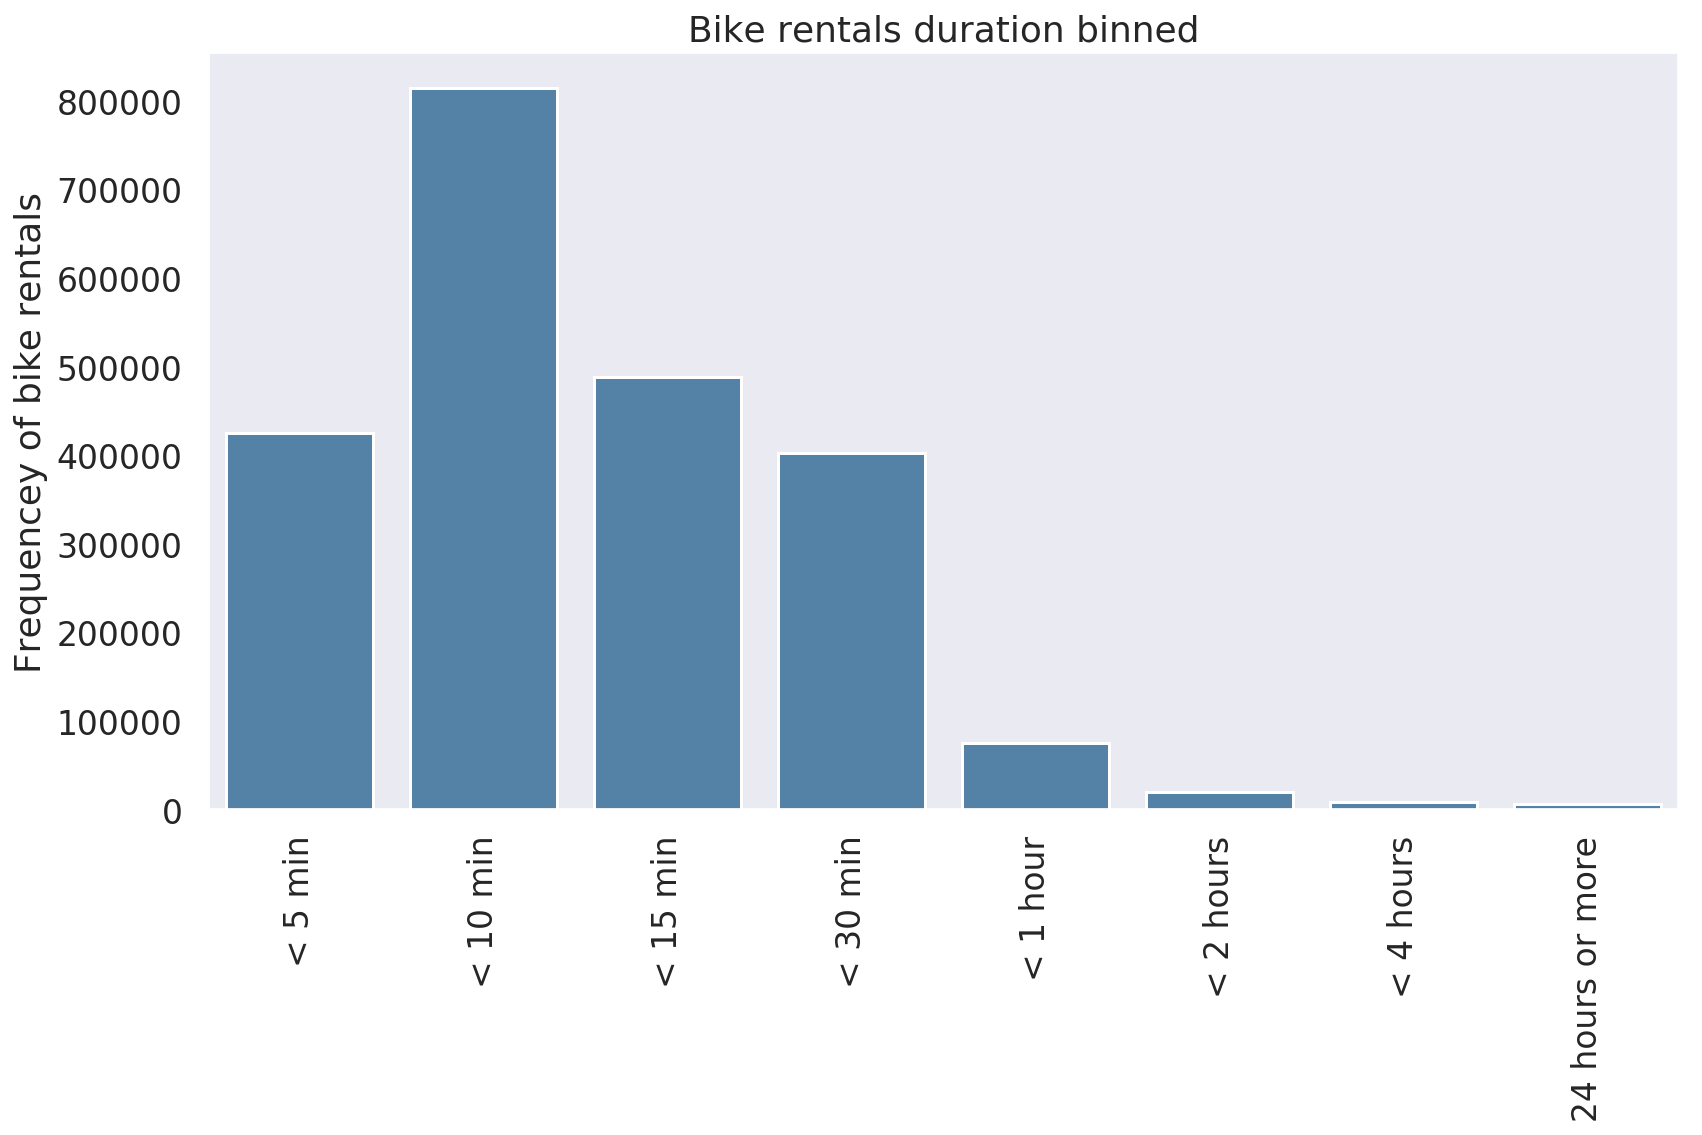

In [32]:
bins = [0, 300, 600, 900, 1800, 3600, 7200, 14400, 86400]
labels = ['< 5 min', '< 10 min', '< 15 min', '< 30 min', '< 1 hour', '< 2 hours', '< 4 hours', '24 hours or more']

duration_quartiles = pd.cut(bikeshare_df['duration_sec'], bins=bins, labels=labels)
binned_duration = duration_quartiles.value_counts(sort=False)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(binned_duration.index, binned_duration, color='steelblue', ax=ax)
ax.set(title='Bike rentals duration binned', xlabel='', ylabel='Frequencey of bike rentals')
ax.tick_params(axis='x', labelrotation=90)

ensure_dir(IMAGES_DIR)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'bike_rental_duration.jpg'))

## 2. During what days of the week does bike rentals occur?  

There are two different user types Customer and Subscribers and Customers are 14 % of renters. Bike rentals mostly occurs on business weekdays with peek bike trips on tuesday, wednesday, and thursdays for Subscribers.

The casual Customer have a small increase during the weekends.

In [4]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

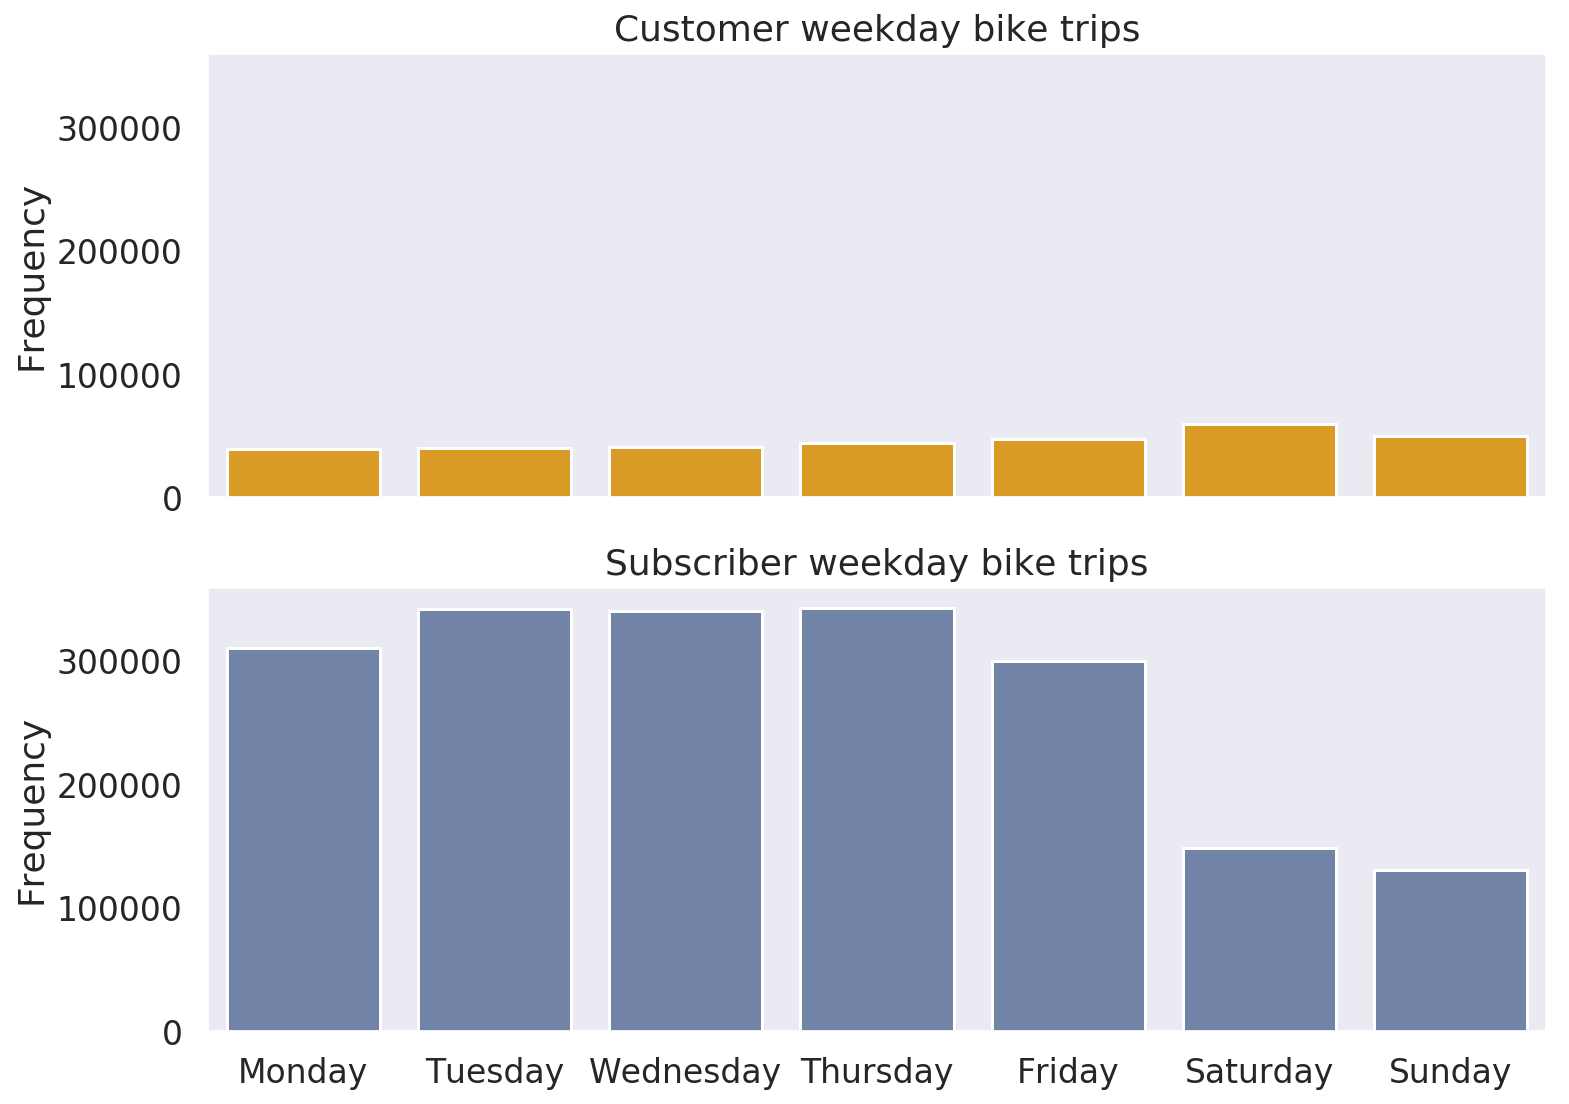

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=True, sharex=True, figsize = (12, 9))

sns.countplot(x='weekday', 
              data=userstart[userstart.user_type == 'Customer'], 
              order=weekday_names, 
              color='orange', 
              saturation=0.7, 
              ax=ax1)
ax1.set(xlabel='', ylabel='Frequency', title='Customer weekday bike trips')

sns.countplot(x='weekday', 
                   data=userstart[userstart.user_type == 'Subscriber'], 
                   order=weekday_names, 
                   color='b', 
                   saturation=0.4, 
                   ax=ax2)
ax2.set(xlabel='', ylabel='Frequency', title='Subscriber weekday bike trips');

## 3. Same station start and end bike trips

When looking at bike trips that start and end at the same station there is a interesting pattern that is revealed in the Customer user type. They have a higher number of these kind of trips than the regular Subscribers. I interpret this as it could be weekend tourists visiting the San Francisco Bay area and are doing more sightseeing kind of trips close to the hotel where they are staying. Than the commuting style usage pattern that the regular Subscribers have.

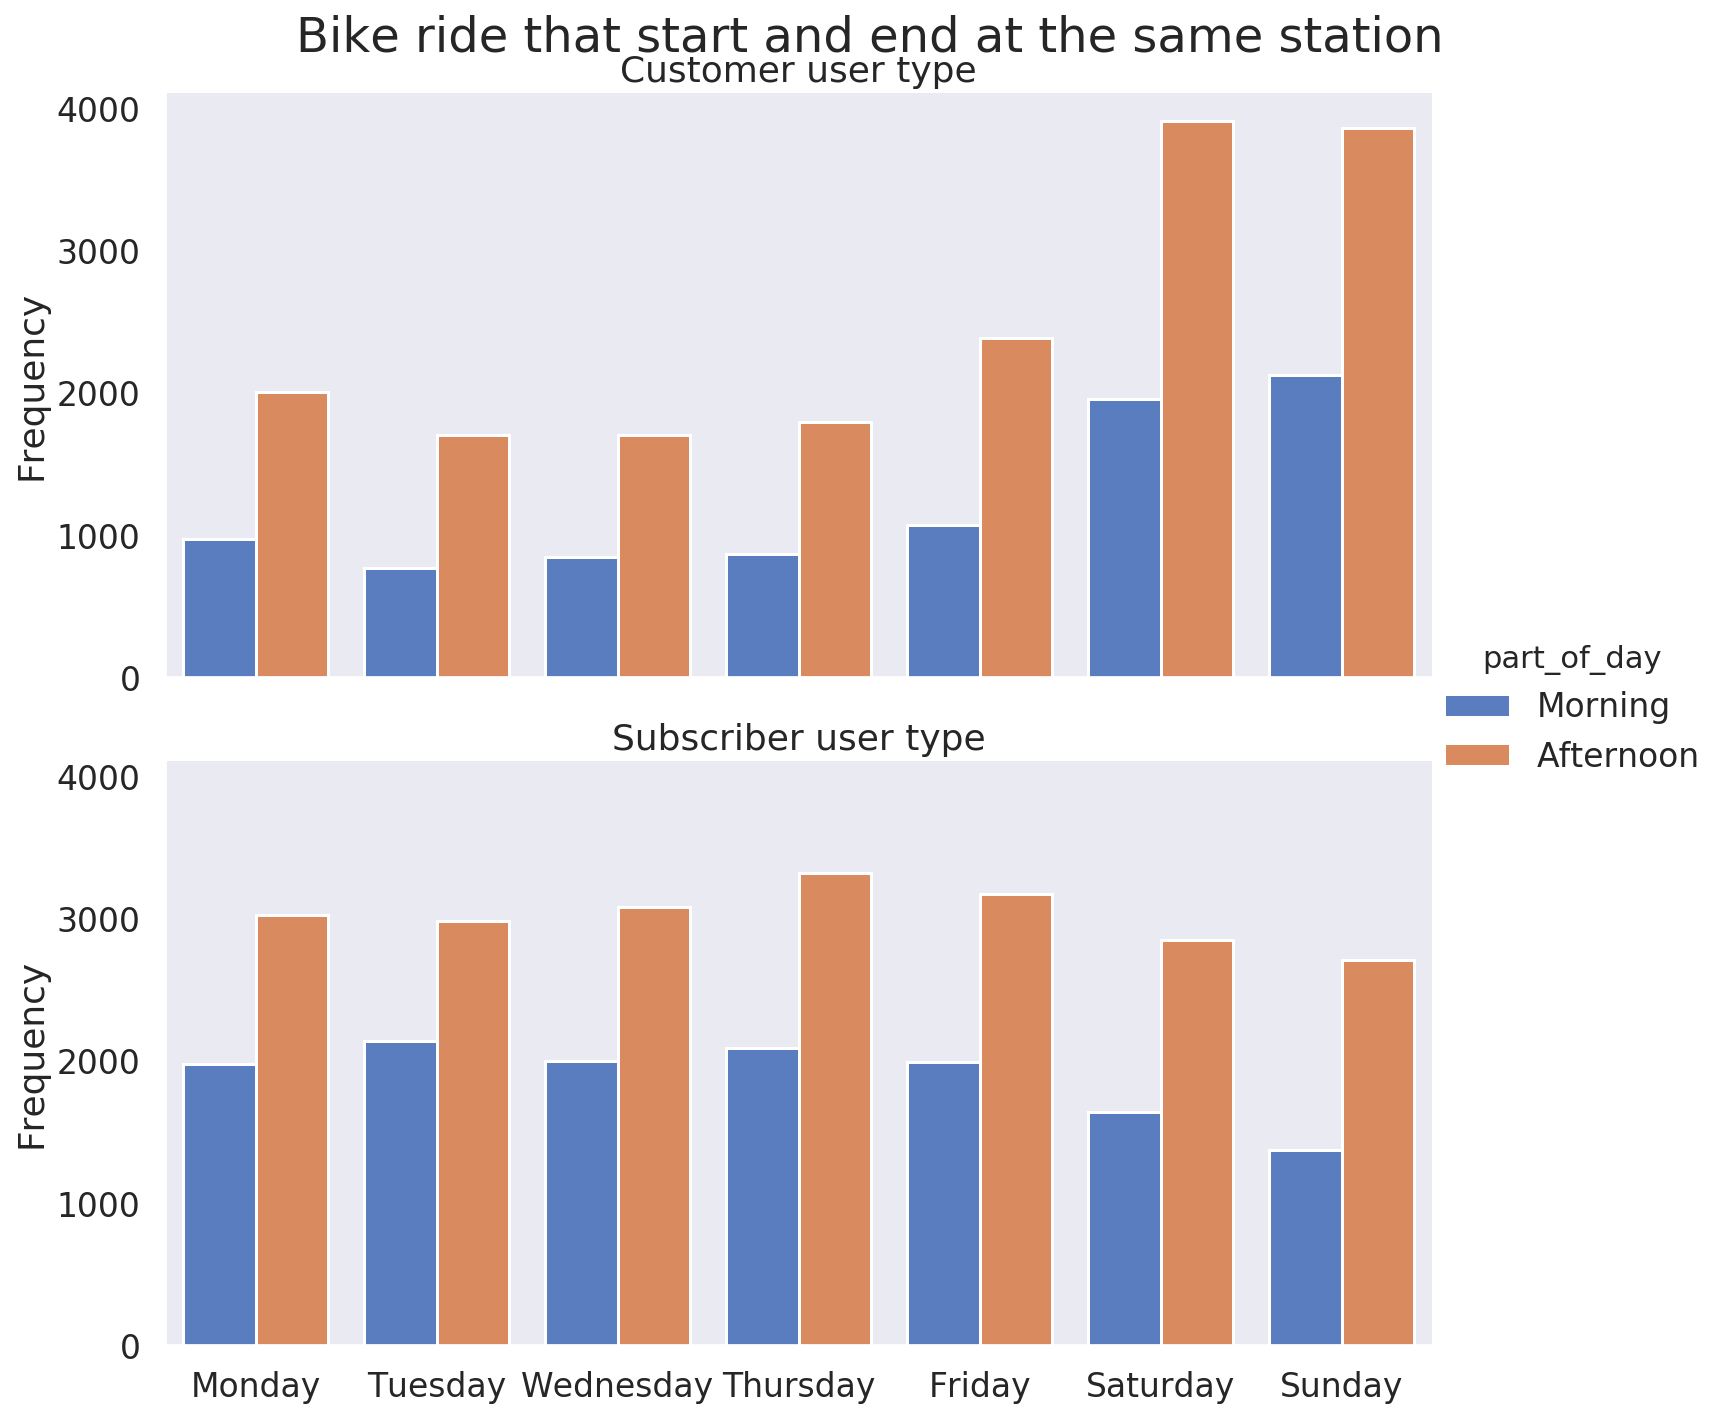

In [33]:
def part_of_day(hour):
    if hour > 12:
        return 'Afternoon'
    else:
        return 'Morning'

same_station = bikeshare_df[bikeshare_df.start_station_id == bikeshare_df.end_station_id].copy()
same_station['weekday'] = same_station.start_time.dt.weekday_name
same_station['part_of_day'] = same_station.start_time.dt.hour.apply(part_of_day)

g = sns.catplot(x='weekday', 
            row='user_type', 
            hue='part_of_day', 
            data=same_station, 
            order=weekday_names,
            hue_order=['Morning', 'Afternoon'],
            kind='count', 
            aspect=2)

g.fig.suptitle('Bike ride that start and end at the same station', verticalalignment='bottom', fontsize=24)
g.set_axis_labels("", "Frequency")
(ax1, ax2) = g.axes.ravel()
ax1.set(title='Customer user type')
ax2.set(title='Subscriber user type');

## 4. Bike rental hour of the day

There is a distinct pattern with two spikes of bike rentals during the day.
One in the morning at 8 o'clock and then later in the evening at 17 o'clock.
This is a really good fit with a commuter pattern with people using bike rentals to travel to and from work. 

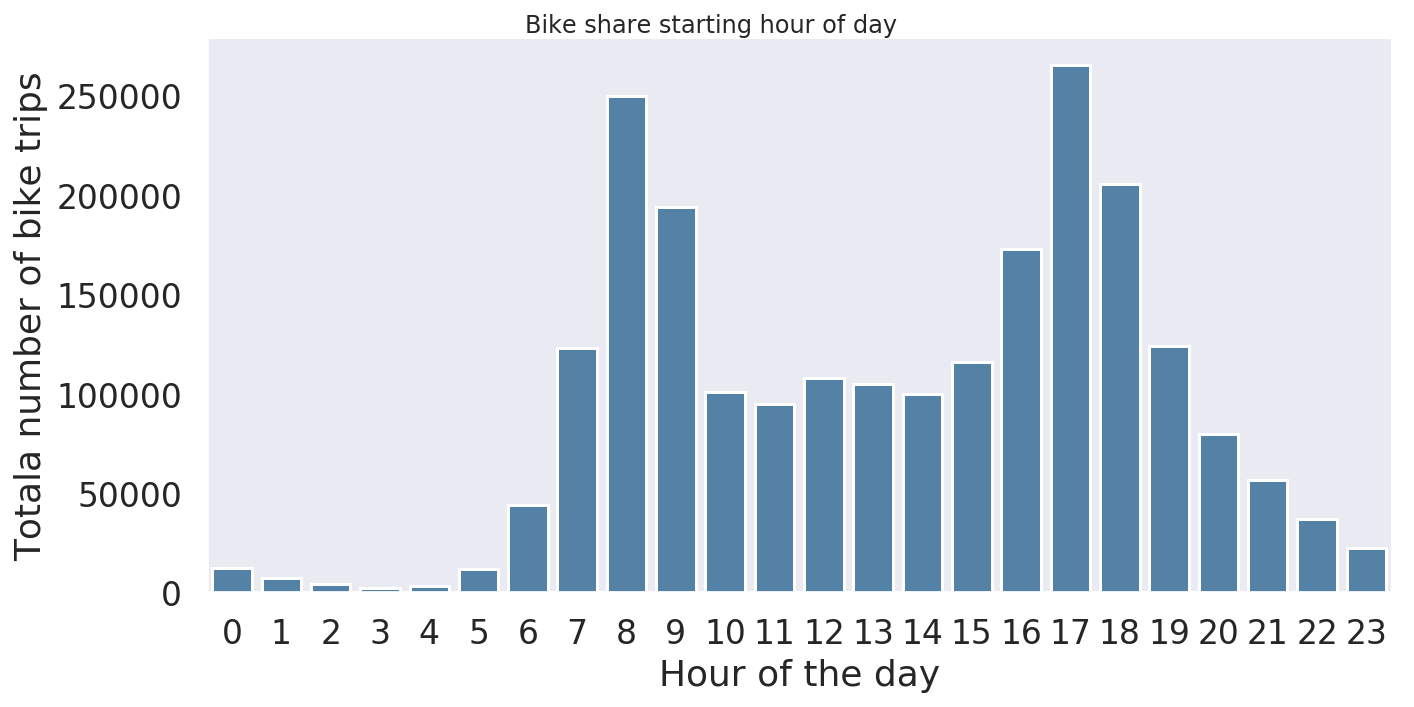

In [7]:
bikeshare_df['hour'] = bikeshare_df.start_time.dt.hour

g = sns.catplot(x='hour',
                data=bikeshare_df,
                kind='count',
                color='steelblue',
                aspect=2)

g.fig.suptitle('Bike share starting hour of day');
g.set(xlabel='Hour of the day', ylabel='Totala number of bike trips')

ensure_dir(IMAGES_DIR)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'bike_rental_hour_of_day.jpg'));

## Summary of Findings

Most bike trips are less than 30 minutes in lenght with less than 10 minutes being the most common.

Bike rentals mostly occurs on business weekdays with peek bike trips on tuesday, wednesday, and thursdays.
When segmenting the bike trips on user type a different pattern is revealed for customers. They have a increase rental frequency on weekends.

Bike trips that start and end at the same station have a increase by Customer user type on weekends. That could be intrepreted that is weekend tourists visiting the San Francisco Bay area and are doing more sightseeing kind of trips close to the hotel where they are staying.

When looking at during which hours of the day bikes are utilized most there are two spike. One in the morning and then later in the evning. This closely matches a commuter style pattern.

## Key Insights for Presentation

The most common duration for a bike trips is less then 10 minutes.

Bike are mostly utilized during business weekdays, Monday trough Friday. Peek hours during the day i 8 o'clock in the morning and 17 o'clock in the evening.

On the weekends there is an increase of bike trips that start and end at the same station.